You can run it at colab

https://colab.research.google.com/drive/1Do_yUGbBzmh3OeXkSoPmVp2zYxqVn59N?usp=sharing


#Train and Evaluation of Hyperparameters

Please import corresponding language data (CSV files) into the same path as this notebook

##Data Process and Input (Skip this if you already have the csv data Set)

Just change the path to the path name of the data file

In [ ]:
def tsvConverter(path, saveName):
  import csv, os
  os.chdir(path)
  def read_text_file(file_path):
      with open(file_path, 'r') as f:
          return f.read()
    
    
  newfile = []
  name = []
  # iterate through all file
  print('start convert')
  idx=1
  for file in os.listdir():
      # Check whether file is in text format or not
      #if file.endswith(".txt"):
        file_path = f"{path}/{file}"

        # call read text file function
        newfile.append(read_text_file(file_path))
        name.append('train')
        print('convert file: ', idx)
        idx+=1
  os.chdir('/content')
  if saveName != None:
    with open(saveName+'.csv','w', newline='') as result_file:
      wr = csv.writer(result_file, dialect='excel')
      wr.writerows(zip(name,newfile))
  
  return newfile


##Package Installation -- <font color='red'> Need to restart runtime after installation</font>

In [ ]:
!pip install octis
!pip install bertopic
!pip install laserembeddings
!python -m laserembeddings download-models
!pip install scikit-learn
!pip install octis==1.10.2
!pip install iso639-lang

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 8.6 MB/s 
     |████████████████████████████████| 170 kB 24.8 MB/s 
     |████████████████████████████████| 100 kB 7.2 MB/s 
     |████████████████████████████████| 16.3 MB 8.5 MB/s 
     |████████████████████████████████| 79 kB 4.5 MB/s 
     |████████████████████████████████| 24.1 MB 3.0 MB/s 
     |████████████████████████████████| 22.3 MB 15.8 MB/s 
     |████████████████████████████████| 4.2 MB 41.2 MB/s 
     |████████████████████████████████| 1.2 MB 39.2 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 40.7 MB/s 
     |████████████████████████████████| 596 kB 22.7 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233370 sha256=f2eed60eaffaa1ea5e0a0931e6d83abb0a855a92530ff46f8a05e5b406d14893
  Stored in directory: /root/.cache/pip/wheel

##Data Loader

In [ ]:
import matplotlib
import sklearn
import srsly
import octis

import re
import nltk
import string
import pandas as pd

from typing import List, Tuple, Union
from octis.dataset.dataset import Dataset
from octis.preprocessing.preprocessing import Preprocessing
from sentence_transformers import SentenceTransformer

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class DataLoader:
    """Prepare and load custom data using OCTIS
    Arguments:
        dataset: The name of the dataset, default options:
                    * trump
                    * 20news
    Usage:
    **Trump** - Unprocessed
    ```python
    from evaluation import DataLoader
    dataloader = DataLoader(dataset="trump").prepare_docs(save="trump.txt").preprocess_octis(output_folder="trump")
    ```
    **20 Newsgroups** - Unprocessed
    ```python
    from evaluation import DataLoader
    dataloader = DataLoader(dataset="20news").prepare_docs(save="20news.txt").preprocess_octis(output_folder="20news")
    ```
    **Custom Data**
    Whenever you want to use a custom dataset (list of strings), make sure to use the loader like this:
    ```python
    from evaluation import DataLoader
    dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs).preprocess_octis(output_folder="my_docs")
    ```
    """

    def __init__(self, dataset: str):
        self.dataset = dataset
        self.docs = None
        self.timestamps = None
        self.octis_docs = None
        self.doc_path = None

    def load_docs(
        self, save: bool = False, docs: List[str] = None
    ) -> Tuple[List[str], Union[List[str], None]]:
        """Load in the documents
        ```python
        dataloader = DataLoader(dataset="trump")
        docs, timestamps = dataloader.load_docs()
        ```
        """
        if docs is not None:
            if save != False:
              self.docs = docs
            else:
              return self.docs, None

        if self.dataset == "trump":
            self.docs, self.timestamps = self._trump()
        elif self.dataset == "trump_dtm":
            self.docs, self.timestamps = self._trump_dtm()
        elif self.dataset == "un_dtm":
            self.docs, self.timestamps = self._un_dtm()
        elif self.dataset == "20news":
            self.docs, self.timestamps = self._20news()

        if save is not None:
            self._save(self.docs, save)

        return self.docs, self.timestamps

    def load_octis(self, custom: bool = False) -> Dataset:
        """Get dataset from OCTIS
        Arguments:
            custom: Whether a custom dataset is used or one retrieved from
                    https://github.com/MIND-Lab/OCTIS#available-datasets
        Usage:
        ```python
        from evaluation import DataLoader
        dataloader = DataLoader(dataset="20news")
        data = dataloader.load_octis(custom=True)
        ```
        """
        data = Dataset()

        if custom:
            data.load_custom_dataset_from_folder(self.dataset)
        else:
            data.fetch_dataset(self.dataset)

        self.octis_docs = data
        return self.octis_docs

    def prepare_docs(self, save: bool = False, docs: List[str] = None):
        """Prepare documents
        Arguments:
            save: The path to save the model to, make sure it ends in .json
            docs: The documents you want to preprocess in OCTIS
        Usage:
        ```python
        from evaluation import DataLoader
        dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs)
        ```
        """
        self.load_docs(save, docs)
        return self

    def preprocess_octis(
        self,
        preprocessor: Preprocessing = None,
        documents_path: str = None,
        output_folder: str = "docs",
    ):
        """Preprocess the data using OCTIS
        Arguments:
            preprocessor: Custom OCTIS preprocessor
            documents_path: Path to the .txt file
            output_folder: Path to where you want to save the preprocessed data
        Usage:
        ```python
        from evaluation import DataLoader
        dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs)
        dataloader.preprocess_octis(output_folder="my_docs")
        ```
        If you want to use your custom preprocessor:
        ```python
        from evaluation import DataLoader
        from octis.preprocessing.preprocessing import Preprocessing
        preprocessor = Preprocessing(lowercase=False,
                                remove_punctuation=False,
                                punctuation=string.punctuation,
                                remove_numbers=False,
                                lemmatize=False,
                                language='english',
                                split=False,
                                verbose=True,
                                save_original_indexes=True,
                                remove_stopwords_spacy=False)
        dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs)
        dataloader.preprocess_octis(preprocessor=preprocessor, output_folder="my_docs")
        ```
        """
        if preprocessor is None:
            preprocessor = Preprocessing(
                lowercase=False,
                remove_punctuation=False,
                punctuation=string.punctuation,
                remove_numbers=False,
                lemmatize=False,
                language="english",
                split=False,
                verbose=True,
                save_original_indexes=True,
                remove_stopwords_spacy=False,
            )
        if not documents_path:
            documents_path = self.doc_path
        dataset = preprocessor.preprocess_dataset(documents_path=documents_path)
        dataset.save(output_folder)

    def _trump(self) -> Tuple[List[str], List[str]]:
        """Prepare the trump dataset"""
        trump = pd.read_csv(
            "https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6"
        )
        trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
        # trump = trump.iloc[0:1000, :]
        timestamps = trump.date.to_list()
        docs = trump.text.to_list()
        docs = [doc.lower().replace("\n", " ") for doc in docs if len(doc) > 2]
        timestamps = [
            timestamp for timestamp, doc in zip(timestamps, docs) if len(doc) > 2
        ]
        return docs, timestamps

    def _trump_dtm(self) -> Tuple[List[str], List[str]]:
        """Prepare the trump dataset including timestamps"""
        trump = pd.read_csv(
            "https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6"
        )
        trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
        timestamps = trump.date.to_list()
        documents = trump.text.to_list()

        docs = []
        time = []
        for doc, timestamp in zip(documents, timestamps):
            if len(doc) > 2:
                docs.append(doc.lower().replace("\n", " "))
                time.append(timestamp)

        # Create bins
        nr_bins = 10
        df = pd.DataFrame({"Doc": docs, "Timestamp": time}).sort_values("Timestamp")
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
        df["Bins"] = pd.cut(df.Timestamp, bins=nr_bins)
        df["Timestamp"] = df.apply(lambda row: row.Bins.left, 1)
        timestamps = df.Timestamp.tolist()
        documents = df.Doc.tolist()

        return docs, timestamps

    def _un_dtm(self) -> Tuple[List[str], List[str]]:
        """Prepare the UN dataset"""

        def create_paragraphs(text):
            text = text.replace("Mr.\n", "Mr. ")
            text = text.replace(".\n", " \p ")
            text = text.replace(". \n ", " \p ")
            text = text.replace(". \n", " \p ")
            text = text.replace("\n", " ")
            text = [x.strip().lower() for x in text.split("\p")]
            return text

        dataset = pd.read_csv(
            "https://runestone.academy/runestone/books/published/httlads/_static/un-general-debates.csv"
        )
        dataset["text"] = dataset.apply(lambda row: create_paragraphs(row.text), 1)
        dataset = dataset.explode("text").sort_values("year")
        dataset = dataset.loc[dataset.year > 2005, :]
        docs = dataset.text.tolist()
        timestamps = dataset.year.tolist()
        return docs, timestamps

    def _save(self, docs: List[str], save: str):
        """Save the documents"""
        with open(save, mode="wt", encoding="utf-8") as myfile:
            myfile.write("\n".join(docs))
        # myfile.close()

        self.doc_path = save

##Preprocessing

###Customized Preprocessor

<font color='red'>**docs is our input data**</font>

In [ ]:
def customPreprocess(language):
  fileName=language+'Data'
  englishData = pd.read_csv(fileName+'.csv')
  englishData = englishData.iloc[:,1]
  docs = englishData.to_list()
  docs = [doc.lower().replace("\n", " ").replace("\xa0", "").replace("\'s", "") for doc in docs if len(doc) > 2]

  preprocessor = Preprocessing(lowercase=False,
                          remove_punctuation=False,
                          punctuation=string.punctuation,
                          remove_numbers=False,
                          lemmatize=False,
                          language=language,
                          split=False,
                          verbose=True,
                          save_original_indexes=True,
                          remove_stopwords_spacy=False)
  dataloader = DataLoader(dataset=fileName).prepare_docs(save=fileName+".txt", docs=docs)
  dataloader.preprocess_octis(preprocessor=preprocessor, output_folder=fileName)
  data = dataloader.load_octis(True)
  data = [" ".join(words) for words in data.get_corpus()]
  return data

###Customized Preprocess English to train

In [ ]:
language = 'english'
fileName=language+'Data'
dataset, custom = fileName, True

data=customPreprocess(language)

created vocab
95421
words filtering done


##Train

###Trainer

In [ ]:
import json
import time
import itertools
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from typing import Mapping, Any, List, Tuple

try:
    from bertopic import BERTopic
except ImportError:
    pass

try:
    from top2vec import Top2Vec
except ImportError:
    pass

try:
    from contextualized_topic_models.models.ctm import CombinedTM
    from contextualized_topic_models.utils.data_preparation import (
        TopicModelDataPreparation,
    )
    import nltk

    nltk.download("stopwords")
    from nltk.corpus import stopwords
except ImportError:
    pass

from octis.models.ETM import ETM
from octis.models.LDA import LDA
from octis.models.NMF import NMF
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel


class Trainer:
    """Train and evaluate a topic model
    Arguments:
        dataset: The dataset to be used, should be a string and either a
                 dataset found in OCTIS or a custom dataset
        model_name: The name of the topic model to be used:
                        * BERTopic
                        * Top2Vec
                        * CTM_CUSTOM (original package)
                        * ETM (OCTIS)
                        * LDA (OCTIS)
                        * CTM (OCTIS)
                        * NMF (OCTIS)
        params: The parameters of the model to be used
        topk: The top n words in each topic to include
        custom_dataset: Whether a custom dataset is used
        bt_embeddings: Pre-trained embeddings used in BERTopic to speed
                       up training.
        bt_timestamps: Timestamps used in BERTopic for dynamic
                       topic modeling
        bt_nr_bins: Number of bins to create from timestamps in BERTopic
        custom_model: A custom BERTopic or Top2Vec class
        verbose: Control the verbosity of the trainer
    Usage:
    ```python
    from evaluation import Trainer
    dataset, custom = "20NewsGroup", False
    params = {"num_topics": [(i+1)*10 for i in range(5)], "random_state": 42}
    trainer = Trainer(dataset=dataset,
                      model_name="LDA",
                      params=params,
                      custom_dataset=custom,
                      verbose=True)
    ```
    Note that we need to specify whether a custom OCTIS dataset is used.
    Since we use a preprocessed dataset from OCTIS [here](https://github.com/MIND-Lab/OCTIS#available-datasets),
    no custom dataset is used.
    This trainer focused on iterating over all combinations of parameters in `params`.
    In the example above, we iterate over different number of topics.
    """

    def __init__(
        self,
        dataset: str,
        model_name: str,
        params: Mapping[str, Any],
        topk: int = 10,
        custom_dataset: bool = False,
        bt_embeddings: np.ndarray = None,
        bt_timestamps: List[str] = None,
        bt_nr_bins: int = None,
        custom_model=None,
        verbose: bool = True,
    ):
        self.dataset = dataset
        self.custom_dataset = custom_dataset
        self.model_name = model_name
        self.params = params
        self.topk = topk
        self.timestamps = bt_timestamps
        self.nr_bins = bt_nr_bins
        self.embeddings = bt_embeddings
        self.ctm_preprocessed_docs = None
        self.custom_model = custom_model
        self.verbose = verbose

        # Prepare data and metrics
        self.data = self.get_dataset()
        self.metrics = self.get_metrics()

        # CTM
        self.qt_ctm = None
        self.training_dataset_ctm = None

    def train(self, save: str = False) -> Mapping[str, Any]:
        """Train a topic model
        Arguments:
            save: The name of the file to save it to.
                  It will be saved as a .json in the current
                  working directory
        Usage:
        ```python
        from evaluation import Trainer
        dataset, custom = "20NewsGroup", False
        params = {"num_topics": [(i+1)*10 for i in range(5)], "random_state": 42}
        trainer = Trainer(dataset=dataset,
                        model_name="LDA",
                        params=params,
                        custom_dataset=custom,
                        verbose=True)
        results = trainer.train(save="LDA_results")
        ```
        """

        results = []

        # Loop over all parameters
        params_name = list(self.params.keys())
        params = {
            param: (value if type(value) == list else [value])
            for param, value in self.params.items()
        }

        new_params = list(itertools.product(*params.values()))
        for param_combo in new_params:

            # Train and evaluate model
            params_to_use = {
                param: value for param, value in zip(params_name, param_combo)
            }
            output, computation_time = self._train_tm_model(params_to_use)
            scores = self.evaluate(output)
            params_to_print=params_to_use
            if type(params_to_use['embedding_model']) != str:
              params_to_print['embedding_model'] = 'LASER'

            # Update results
            result = {
                "Dataset": self.dataset,
                "Dataset Size": len(self.data.get_corpus()),
                "Model": self.model_name,
                "Params": params_to_print,
                "Scores": scores,
                "Computation Time": computation_time,
            }
            results.append(result)

        if save:
            with open(f"{save}.json", "w") as f:
                json.dump(results, f)

            try:
                from google.colab import files

                files.download(f"{save}.json")
            except ImportError:
                pass

        return results

    def _train_tm_model(
        self, params: Mapping[str, Any]
    ) -> Tuple[Mapping[str, Any], float]:
        """Select and train the Topic Model"""
        # Train custom CTM
        if self.model_name == "CTM_CUSTOM":
            if self.qt_ctm is None:
                self._preprocess_ctm()
            return self._train_ctm(params)

        # Train BERTopic
        elif self.model_name == "BERTopic":
            return self._train_bertopic(params)

        # Train Top2Vec
        elif self.model_name == "Top2Vec":
            return self._train_top2vec(params)

        # Train LDAseq
        elif self.model_name == "LDAseq":
            return self._train_ldaseq(params)

        # Train OCTIS model
        octis_models = ["ETM", "LDA", "CTM", "NMF"]
        if self.model_name in octis_models:
            return self._train_octis_model(params)

    def _train_ldaseq(
        self, params: Mapping[str, any]
    ) -> Tuple[Mapping[str, Any], float]:
        """Train LDA seq model"""
        data = self.data.get_corpus()
        docs = [" ".join(words) for words in data]

        df = pd.DataFrame({"Doc": docs, "Timestamp": self.timestamps}).sort_values(
            "Timestamp"
        )
        df["Bins"] = pd.cut(df.Timestamp, bins=params["nr_bins"])
        df["Timestamp"] = df.apply(lambda row: row.Bins.left, 1)
        timestamps = df.groupby("Bins").count().Timestamp.values
        docs = df.Doc.values

        data_words = list(sent_to_words(docs))
        id2word = corpora.Dictionary(data_words)
        corpus = [id2word.doc2bow(text) for text in data_words]

        print(len(corpus), len(self.timestamps), timestamps)

        params["corpus"] = corpus
        params["id2word"] = id2word
        params["time_slice"] = timestamps
        del params["nr_bins"]

        start = time.time()
        ldaseq = ldaseqmodel.LdaSeqModel(**params)
        end = time.time()
        computation_time = end - start

        all_topics = {}
        for i in range(len(timestamps)):
            topics = ldaseq.print_topics(time=i)
            topics = [[word for word, _ in topic][:5] for topic in topics]
            all_topics[i] = {"topics": topics}

        return all_topics, computation_time

    def _train_top2vec(
        self, params: Mapping[str, Any]
    ) -> Tuple[Mapping[str, Any], float]:
        """Train Top2Vec"""
        nr_topics = None
        data = self.data.get_corpus()
        data = [" ".join(words) for words in data]
        params["documents"] = data

        if params.get("nr_topics"):
            nr_topics = params["nr_topics"]
            del params["nr_topics"]

        start = time.time()

        if self.custom_model is not None:
            model = self.custom_model(**params)
        else:
            model = Top2Vec(**params)

        if nr_topics:
            try:
                _ = model.hierarchical_topic_reduction(nr_topics)
                params["reduction"] = True
                params["nr_topics"] = nr_topics
            except:
                params["reduction"] = False
                nr_topics = False

        end = time.time()
        computation_time = float(end - start)

        if nr_topics:
            topic_words, _, _ = model.get_topics(reduced=True)
        else:
            topic_words, _, _ = model.get_topics(reduced=False)

        topics_old = [list(topic[:10]) for topic in topic_words]
        all_words = [word for words in self.data.get_corpus() for word in words]
        topics = []
        for topic in topics_old:
            words = []
            for word in topic:
                if word in all_words:
                    words.append(word)
                else:
                    print(f"error: {word}")
                    words.append(all_words[0])
            topics.append(words)

        if not nr_topics:
            params["nr_topics"] = len(topics)
            params["reduction"] = False

        del params["documents"]
        output_tm = {
            "topics": topics,
        }
        return output_tm, computation_time

    def _train_ctm(self, params) -> Tuple[Mapping[str, Any], float]:
        """Train CTM"""
        params["bow_size"] = len(self.qt_ctm.vocab)
        ctm = CombinedTM(**params)

        start = time.time()
        ctm.fit(self.training_dataset_ctm)
        end = time.time()
        computation_time = float(end - start)

        topics = ctm.get_topics(10)
        topics = [topics[x] for x in topics]

        output_tm = {
            "topics": topics,
        }

        return output_tm, computation_time

    def _preprocess_ctm(self):
        """Preprocess data for CTM"""
        # Prepare docs
        data = self.data.get_corpus()
        docs = [" ".join(words) for words in data]

        # Remove stop words
        stop_words = stopwords.words("english")
        preprocessed_documents = [
            " ".join([x for x in doc.split(" ") if x not in stop_words]).strip()
            for doc in docs
        ]

        # Get vocabulary
        vectorizer = CountVectorizer(
            max_features=2000, token_pattern=r"\b[a-zA-Z]{2,}\b"
        )
        vectorizer.fit_transform(preprocessed_documents)
        vocabulary = set(vectorizer.get_feature_names())

        # Preprocess documents further
        preprocessed_documents = [
            " ".join([w for w in doc.split() if w in vocabulary]).strip()
            for doc in preprocessed_documents
        ]

        # Prepare CTM data
        qt = TopicModelDataPreparation("all-mpnet-base-v2")
        training_dataset = qt.fit(
            text_for_contextual=docs, text_for_bow=preprocessed_documents
        )

        self.qt_ctm = qt
        self.training_dataset_ctm = training_dataset

    def _train_octis_model(
        self, params: Mapping[str, any]
    ) -> Tuple[Mapping[str, Any], float]:
        """Train OCTIS model"""

        if self.model_name == "ETM":
            model = ETM(**params)
            model.use_partitions = False
        elif self.model_name == "LDA":
            model = LDA(**params)
            model.use_partitions = False
        elif self.model_name == "CTM":
            model = CTM(**params)
            model.use_partitions = False
        elif self.model_name == "NMF":
            model = NMF(**params)
            model.use_partitions = False

        start = time.time()
        output_tm = model.train_model(self.data)
        end = time.time()
        computation_time = end - start
        return output_tm, computation_time

    def _train_bertopic(
        self, params: Mapping[str, any]
    ) -> Tuple[Mapping[str, Any], float]:
        """Train BERTopic model"""
        data = self.data.get_corpus()
        data = [" ".join(words) for words in data]
        params["calculate_probabilities"] = False

        if self.custom_model is not None:
            model = self.custom_model(**params)
        else:
            model = BERTopic(**params)

        start = time.time()
        topics, _ = model.fit_transform(data, self.embeddings)

        # Dynamic Topic Modeling
        if self.timestamps:
            topics_over_time = model.topics_over_time(
                data,
                topics,
                self.timestamps,
                nr_bins=self.nr_bins,
                evolution_tuning=False,
                global_tuning=False,
            )
            unique_timestamps = topics_over_time.Timestamp.unique()
            dtm_topics = {}
            for unique_timestamp in unique_timestamps:
                dtm_topic = topics_over_time.loc[
                    topics_over_time.Timestamp == unique_timestamp, :
                ].sort_values("Frequency", ascending=True)
                dtm_topic = dtm_topic.loc[dtm_topic.Topic != -1, :]
                dtm_topic = [topic.split(", ") for topic in dtm_topic.Words.values]
                dtm_topics[unique_timestamp] = {"topics": dtm_topic}

                all_words = [word for words in self.data.get_corpus() for word in words]

                updated_topics = []
                for topic in dtm_topic:
                    updated_topic = []
                    for word in topic:
                        if word not in all_words:
                            print(word)
                            updated_topic.append(all_words[0])
                        else:
                            updated_topic.append(word)
                    updated_topics.append(updated_topic)

                dtm_topics[unique_timestamp] = {"topics": updated_topics}

            output_tm = dtm_topics

        end = time.time()
        computation_time = float(end - start)

        if not self.timestamps:
            all_words = [word for words in self.data.get_corpus() for word in words]
            bertopic_topics = [
                [
                    vals[0] if vals[0] in all_words else all_words[0]
                    for vals in model.get_topic(i)[:10]
                ]
                for i in range(len(set(topics)) - 1)
            ]

            output_tm = {"topics": bertopic_topics}

        return output_tm, computation_time

    def evaluate(self, output_tm):
        """Using metrics and output of the topic model, evaluate the topic model"""
        if self.timestamps:
            results = {str(timestamp): {} for timestamp, _ in output_tm.items()}
            for timestamp, topics in output_tm.items():
                self.metrics = self.get_metrics()
                for scorers, _ in self.metrics:
                    for scorer, name in scorers:
                        score = scorer.score(topics)
                        results[str(timestamp)][name] = float(score)

        else:
            # Calculate results
            results = {}
            for scorers, _ in self.metrics:
                for scorer, name in scorers:
                    score = scorer.score(output_tm)
                    results[name] = float(score)

            # Print results
            if self.verbose:
                print("Results")
                print("============")
                for metric, score in results.items():
                    print(f"{metric}: {str(score)}")
                print(" ")

        return results

    def get_dataset(self):
        """Get dataset from OCTIS"""
        data = Dataset()

        if self.custom_dataset:
            data.load_custom_dataset_from_folder(self.dataset)
        else:
            data.fetch_dataset(self.dataset)
        return data

    def get_metrics(self):
        """Prepare evaluation measures using OCTIS"""
        npmi = Coherence(texts=self.data.get_corpus(), topk=self.topk, measure="c_npmi")
        topic_diversity = TopicDiversity(topk=self.topk)

        # Define methods
        coherence = [(npmi, "npmi")]
        diversity = [(topic_diversity, "diversity")]
        metrics = [(coherence, "Coherence"), (diversity, "Diversity")]

        return metrics


def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))

###Train Example

Prepare the raw data to feed into model

In [ ]:
#check different min topic parameters
min_topic_size=[3 ,4, 5, 6, 7, 8, 9, 10]

#check different nr_topics parameters
# nr_topics=[(i+1)*10 for i in range(5)]
nr_topics=50

Extract embeddings from data (<font color='red'>**We change our embeddings here**</font>)

####MiniLM Model

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer
# Extract embeddings
MiniLM = "paraphrase-multilingual-MiniLM-L12-v2"
modelMiniLM = SentenceTransformer(MiniLM)
embeddingsMiniLM = modelMiniLM.encode(data, show_progress_bar=True)

In [ ]:
embeddingsMiniLM.shape

In [ ]:
#Following params is BERTopic params
#Check here to pass different embedding models
#https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html
for i in range(3):
    params = {
        "embedding_model": MiniLM,
        "nr_topics": nr_topics,
        "min_topic_size": min_topic_size,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsMiniLM,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"BERTopic_MiniLM_{i+1}")

####LaBSE Model

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer
# Extract embeddings
# LaBSE = "sentence-transformers/LaBSE"
LaBSE = "LaBSE"
modelLaBSE = SentenceTransformer(LaBSE)
embeddingsLaBSE = modelLaBSE.encode(data, show_progress_bar=True)

In [ ]:
# from flair.embeddings import TransformerDocumentEmbeddings

# roberta = TransformerDocumentEmbeddings('roberta-base')

In [ ]:
embeddingsLaBSE.shape

In [ ]:
#Following params is BERTopic params
#Check here to pass different embedding models
#https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html
for i in range(3):
    params = {
        "embedding_model": LaBSE,
        "nr_topics": nr_topics,
        "min_topic_size": min_topic_size,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLaBSE,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"BERTopic_LaBSE_{i+1}")

####LASER Model

In [ ]:
%%capture
from laserembeddings import Laser
modelLaser = Laser()

# Extract embeddings
LASER = "LASER"
embeddingsLASER = modelLaser.embed_sentences(data, lang='en')
# embeddings = np.vstack([np.mean(model.embed_sentences(data[i], lang='en'), axis=0) for i in range(len(data))])

In [ ]:
embeddingsLASER.shape

In [ ]:
from bertopic.backend import BaseEmbedder
from sentence_transformers import SentenceTransformer

class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.embed_sentences(documents, lang='en')
        return embeddings 

# Create custom backend
custom_embedder = CustomEmbedder(embedding_model=modelLaser)

# # # Pass custom backend to bertopic
# topic_model = BERTopic(embedding_model=custom_embedder).fit(docs)

In [ ]:
#Following params is BERTopic params
#Check here to pass different embedding models
#https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html
for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": nr_topics,
        "min_topic_size": min_topic_size,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"BERTopic_LASER_{i+1}")

###Plot and compare

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

def extractInfo(data):
  return data.join(pd.json_normalize(data['Params']))\
    .drop(columns=['diversity'])\
    .join(pd.json_normalize(data['Scores']))

def averageScore(data1, data2, data3):
  data1=extractInfo(data1)
  data2=extractInfo(data2)
  data3=extractInfo(data3)
  columns=['nr_topics','min_topic_size', 'npmi', 'diversity']
  new1=data1[columns].copy()
  new2=data2[columns].copy()
  new3=data3[columns].copy()
  average=pd.concat([new1,new2, new3]).groupby(level=0).mean()
  return average


def plotGraph(data, title):
  ax=data.loc[data['min_topic_size'] == 5].plot(x="nr_topics", y=["npmi", "diversity"], title=title, figsize=(15, 10))
  data.loc[data['min_topic_size'] == 7].plot(x="nr_topics", y=["npmi", "diversity"], title=title, ax=ax, figsize=(15, 10))
  data.loc[data['min_topic_size'] == 10].plot(x="nr_topics", y=["npmi", "diversity"], title=title, ax=ax, figsize=(15, 10))
  ax.legend(["npmi5", "diversity5", "npmi7", "diversity7", "npmi10", "diversity10"])

def plotGraph2(data, title):
  ax=data.plot(x="min_topic_size", y=["npmi", "diversity"], title=title, figsize=(15, 10))
  # data.loc[data['min_topic_size'] == 4].plot(x="nr_topics", y=["npmi", "diversity"], title=title, ax=ax, figsize=(15, 10))
  # data.loc[data['min_topic_size'] == 5].plot(x="nr_topics", y=["npmi", "diversity"], title=title, ax=ax, figsize=(15, 10))
  # ax.legend(["npmi5", "diversity5", "npmi7", "diversity7", "npmi10", "diversity10"])




In [2]:
laser1=pd.read_json('BERTopic_LASER_1.json')
laser2=pd.read_json('BERTopic_LASER_2.json')
laser3=pd.read_json('BERTopic_LASER_3.json')
labse1=pd.read_json('BERTopic_LaBSE_1.json')
labse2=pd.read_json('BERTopic_LaBSE_2.json')
labse3=pd.read_json('BERTopic_LaBSE_3.json')
mini1=pd.read_json('BERTopic_MiniLM_1.json')
mini2=pd.read_json('BERTopic_MiniLM_2.json')
mini3=pd.read_json('BERTopic_MiniLM_3.json')



laser=averageScore(laser1, laser2, laser3)
labse=averageScore(labse1, labse2, labse3)
mini=averageScore(mini1, mini2, mini3)

In [3]:
laser

,nr_topics,min_topic_size,npmi,diversity
0,50.0,3.0,0.105085,0.647333
1,50.0,4.0,0.117033,0.690000
2,50.0,5.0,0.120658,0.661333
3,50.0,6.0,0.111292,0.652769
4,50.0,7.0,0.112501,0.670000
5,50.0,8.0,0.096531,0.646061
6,50.0,9.0,0.116306,0.674667
7,50.0,10.0,0.080885,0.648000


In [4]:
labse

,nr_topics,min_topic_size,npmi,diversity
0,50.0,3.0,0.104177,0.648667
1,50.0,4.0,0.105615,0.648000
2,50.0,5.0,0.106148,0.633333
3,50.0,6.0,0.106909,0.640667
4,50.0,7.0,0.102371,0.642667
5,50.0,8.0,0.108988,0.656000
6,50.0,9.0,0.100075,0.633333
7,50.0,10.0,0.103174,0.644667


In [5]:
mini

,nr_topics,min_topic_size,npmi,diversity
0,50.0,3.0,0.099768,0.614667
1,50.0,4.0,0.095379,0.609333
2,50.0,5.0,0.094893,0.605333
3,50.0,6.0,0.098519,0.609333
4,50.0,7.0,0.094506,0.602667
5,50.0,8.0,0.098992,0.618667
6,50.0,9.0,0.097483,0.604667
7,50.0,10.0,0.093416,0.605333


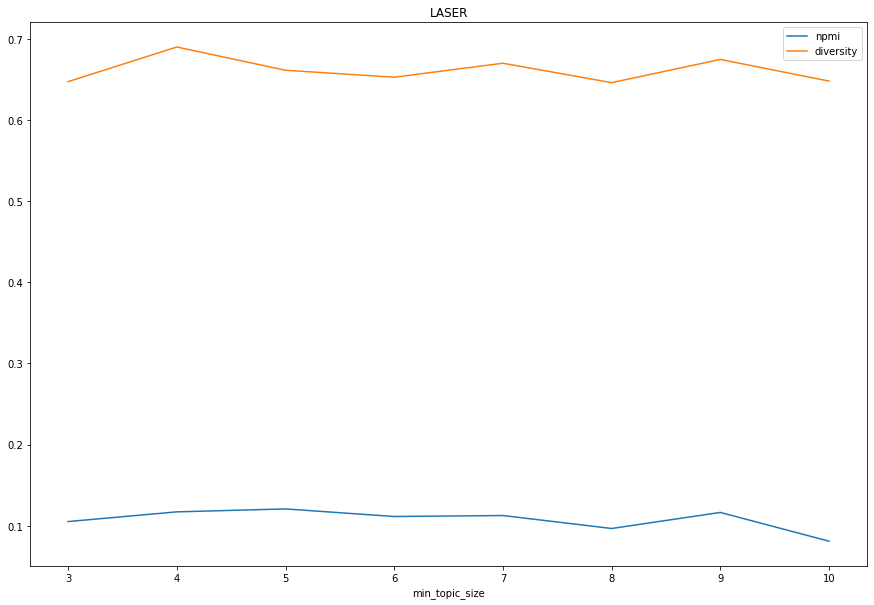

In [6]:
# ax=laser.loc[laser['min_topic_size'] == 5].plot(x="nr_topics", y=["npmi", "diversity"], title='LASER')
# laser.loc[laser['min_topic_size'] == 7].plot(x="nr_topics", y=["npmi", "diversity"], title='LASER', ax=ax)
# laser.loc[laser['min_topic_size'] == 10].plot(x="nr_topics", y=["npmi", "diversity"], title='LASER', ax=ax)
# ax.legend(["npmi5", "diversity5", "npmi7", "diversity7", "npmi10", "diversity10"]);
plotGraph2(laser, 'LASER')

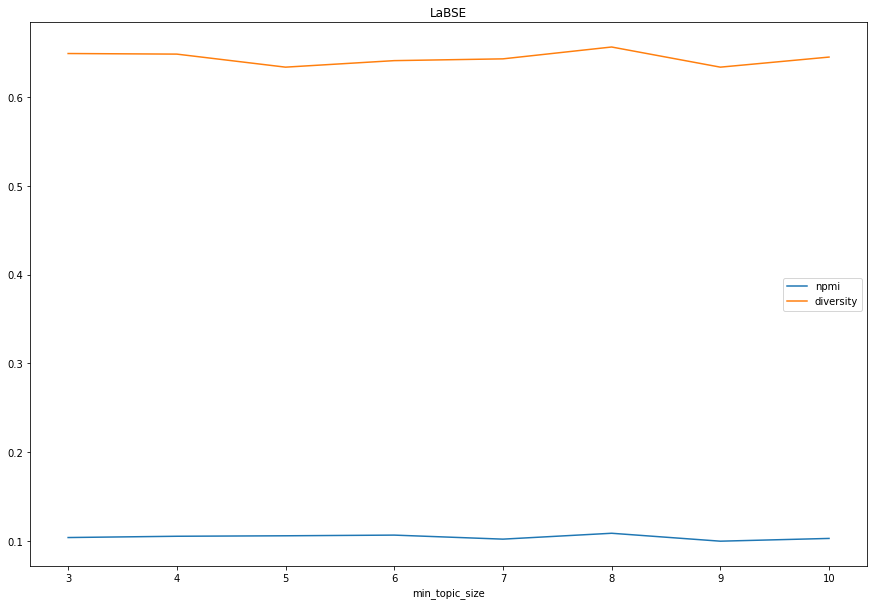

In [7]:
# labse.plot(x="nr_topics", y=["npmi", "diversity"], title='LaBSE')
plotGraph2(labse, 'LaBSE')

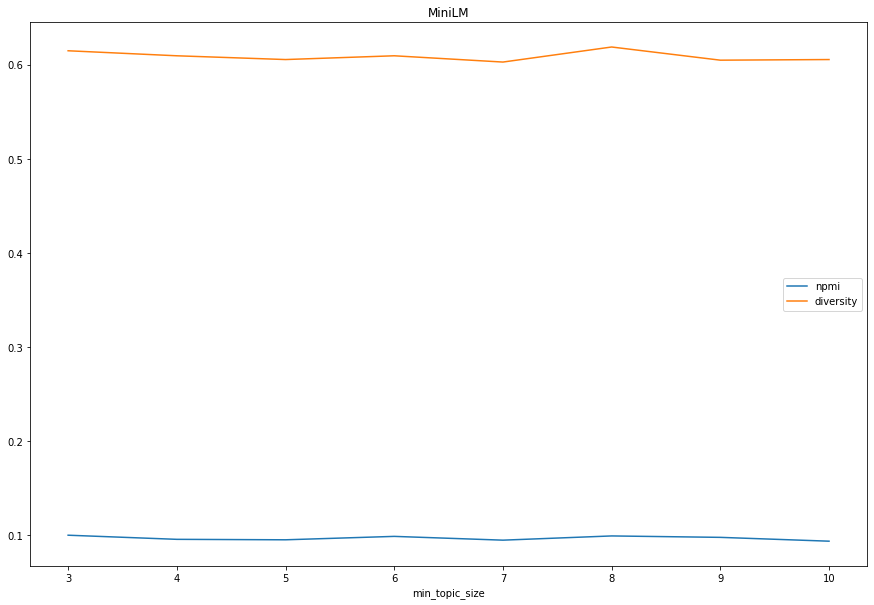

In [8]:
plotGraph2(mini, 'MiniLM')

**Comparison:**
For the parameters we compare, we could see following:

MiniLM:

nr_topics:50
min_topic_size:8

LaBSE:

nr_topics:50
min_topic_size:8


LASER:

nr_topics:50
min_topic_size:5

#Test

In [ ]:
minMini=8
minLabse=8
minLaser=5

##English

Change the language name here. The rest should just run fine

In [ ]:
language = 'english'

###Load Data

In [ ]:
fileName=language+'Data'
dataset, custom = fileName, True

data=customPreprocess(language)

created vocab
95421
words filtering done


###Testing

####MiniLM

In [ ]:
# Extract embeddings
MiniLM = "paraphrase-multilingual-MiniLM-L12-v2"
modelMiniLM = SentenceTransformer(MiniLM)
embeddingsMiniLM = modelMiniLM.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": MiniLM,
        "nr_topics": 50,
        "min_topic_size": minMini,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsMiniLM,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_MiniLM_{i+1}")

Batches:   0%|          | 0/397 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-05-26 16:55:37,079 - BERTopic - Reduced dimensionality
2022-05-26 16:55:37,856 - BERTopic - Clustered reduced embeddings
2022-05-26 16:55:51,325 - BERTopic - Reduced number of topics from 247 to 51


Results
npmi: 0.08886910627933015
diversity: 0.59
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 16:57:37,482 - BERTopic - Reduced dimensionality
2022-05-26 16:57:38,318 - BERTopic - Clustered reduced embeddings
2022-05-26 16:57:51,291 - BERTopic - Reduced number of topics from 250 to 51


Results
npmi: 0.096876619505439
diversity: 0.616
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 16:59:38,930 - BERTopic - Reduced dimensionality
2022-05-26 16:59:39,761 - BERTopic - Clustered reduced embeddings
2022-05-26 16:59:53,526 - BERTopic - Reduced number of topics from 261 to 51


Results
npmi: 0.09936039643555336
diversity: 0.616
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LaBSE

In [ ]:
# Extract embeddings
LaBSE = "LaBSE"
modelLaBSE = SentenceTransformer(LaBSE)
embeddingsLaBSE = modelLaBSE.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": LaBSE,
        "nr_topics": 50,
        "min_topic_size": minLabse,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLaBSE,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LaBSE_{i+1}")

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Batches:   0%|          | 0/397 [00:00<?, ?it/s]

2022-05-26 17:05:48,295 - BERTopic - Reduced dimensionality
2022-05-26 17:05:49,149 - BERTopic - Clustered reduced embeddings
2022-05-26 17:06:02,164 - BERTopic - Reduced number of topics from 199 to 51


Results
npmi: 0.10956407959283039
diversity: 0.646
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:07:54,286 - BERTopic - Reduced dimensionality
2022-05-26 17:07:55,051 - BERTopic - Clustered reduced embeddings
2022-05-26 17:08:08,337 - BERTopic - Reduced number of topics from 208 to 51


Results
npmi: 0.10771766142795611
diversity: 0.64
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:09:59,296 - BERTopic - Reduced dimensionality
2022-05-26 17:10:00,042 - BERTopic - Clustered reduced embeddings
2022-05-26 17:10:12,825 - BERTopic - Reduced number of topics from 209 to 51


Results
npmi: 0.10452488971113956
diversity: 0.652
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LASER

In [ ]:
from laserembeddings import Laser
from iso639 import Lang
from bertopic.backend import BaseEmbedder

languageShort=Lang(language.capitalize()).pt1

modelLaser = Laser()

# Extract embeddings
LASER = "LASER"
embeddingsLASER = modelLaser.embed_sentences(data, lang=languageShort)


class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.embed_sentences(documents, lang=languageShort)
        return embeddings 

# Create custom backend
custom_embedder = CustomEmbedder(embedding_model=modelLaser)

for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": 50,
        "min_topic_size": minLaser,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LASER_{i+1}")

2022-05-26 17:14:32,095 - BERTopic - Reduced dimensionality
2022-05-26 17:14:32,933 - BERTopic - Clustered reduced embeddings
2022-05-26 17:14:44,666 - BERTopic - Reduced number of topics from 176 to 51


Results
npmi: 0.1110812894220422
diversity: 0.676
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:16:28,525 - BERTopic - Reduced dimensionality
2022-05-26 17:16:29,331 - BERTopic - Clustered reduced embeddings
2022-05-26 17:16:40,623 - BERTopic - Reduced number of topics from 165 to 51


Results
npmi: 0.11680991381832123
diversity: 0.682
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:18:21,871 - BERTopic - Reduced dimensionality
2022-05-26 17:18:22,688 - BERTopic - Clustered reduced embeddings
2022-05-26 17:18:34,383 - BERTopic - Reduced number of topics from 168 to 51


Results
npmi: 0.1290220931121812
diversity: 0.674
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Result Processing

In [ ]:
import pandas as pd

laser1=pd.read_json(language+'_LASER_1.json')
laser2=pd.read_json(language+'_LASER_2.json')
laser3=pd.read_json(language+'_LASER_3.json')
labse1=pd.read_json(language+'_LaBSE_1.json')
labse2=pd.read_json(language+'_LaBSE_2.json')
labse3=pd.read_json(language+'_LaBSE_3.json')
mini1=pd.read_json(language+'_MiniLM_1.json')
mini2=pd.read_json(language+'_MiniLM_2.json')
mini3=pd.read_json(language+'_MiniLM_3.json')

def extractInfo(data):
  return data.join(pd.json_normalize(data['Params']))\
    .drop(columns=['diversity'])\
    .join(pd.json_normalize(data['Scores']))

def averageScore(data1, data2, data3):
  data1=extractInfo(data1)
  data2=extractInfo(data2)
  data3=extractInfo(data3)
  columns=['nr_topics','min_topic_size', 'npmi', 'diversity']
  new1=data1[columns].copy()
  new2=data2[columns].copy()
  new3=data3[columns].copy()
  average=pd.concat([new1,new2, new3]).groupby(level=0).mean()
  return average

laser=averageScore(laser1, laser2, laser3)
labse=averageScore(labse1, labse2, labse3)
mini=averageScore(mini1, mini2, mini3)


###Result

In [ ]:
finalResults = pd.concat([laser, labse, mini])
finalResults=finalResults.set_axis(['LASER', 'LaBSE', 'MiniLM'],axis='index')
display(finalResults)

,nr_topics,min_topic_size,npmi,diversity
LASER,50.0,5.0,0.118971,0.677333
LaBSE,50.0,8.0,0.107269,0.646000
MiniLM,50.0,8.0,0.095035,0.607333


##Arabic

Change the language name here. The rest should just run fine

In [ ]:
language = 'arabic'

###Load Data

In [ ]:
fileName=language+'Data'
dataset, custom = fileName, True

data=customPreprocess(language)

created vocab
70536
words filtering done


###Testing

####MiniLM

In [ ]:
# Extract embeddings
MiniLM = "paraphrase-multilingual-MiniLM-L12-v2"
modelMiniLM = SentenceTransformer(MiniLM)
embeddingsMiniLM = modelMiniLM.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": MiniLM,
        "nr_topics": 50,
        "min_topic_size": minMini,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsMiniLM,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_MiniLM_{i+1}")

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

2022-05-26 17:20:33,610 - BERTopic - Reduced dimensionality
2022-05-26 17:20:33,690 - BERTopic - Clustered reduced embeddings
2022-05-26 17:20:35,069 - BERTopic - Reduced number of topics from 37 to 37


Results
npmi: 0.025489264137398087
diversity: 0.6277777777777778
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:20:59,869 - BERTopic - Reduced dimensionality
2022-05-26 17:20:59,948 - BERTopic - Clustered reduced embeddings
2022-05-26 17:21:01,151 - BERTopic - Reduced number of topics from 36 to 36


Results
npmi: 0.032750782473363806
diversity: 0.62
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:21:26,507 - BERTopic - Reduced dimensionality
2022-05-26 17:21:26,599 - BERTopic - Clustered reduced embeddings
2022-05-26 17:21:27,804 - BERTopic - Reduced number of topics from 37 to 37


Results
npmi: 0.029731656012742178
diversity: 0.6333333333333333
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LaBSE

In [ ]:
# Extract embeddings
LaBSE = "LaBSE"
modelLaBSE = SentenceTransformer(LaBSE)
embeddingsLaBSE = modelLaBSE.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": LaBSE,
        "nr_topics": 50,
        "min_topic_size": minLabse,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLaBSE,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LaBSE_{i+1}")

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

2022-05-26 17:22:22,344 - BERTopic - Reduced dimensionality
2022-05-26 17:22:22,436 - BERTopic - Clustered reduced embeddings
2022-05-26 17:22:24,324 - BERTopic - Reduced number of topics from 33 to 33


Results
npmi: 0.0343395544037329
diversity: 0.59375
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:22:53,908 - BERTopic - Reduced dimensionality
2022-05-26 17:22:53,989 - BERTopic - Clustered reduced embeddings
2022-05-26 17:22:55,565 - BERTopic - Reduced number of topics from 33 to 33


Results
npmi: 0.034741093884506476
diversity: 0.60625
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:23:25,522 - BERTopic - Reduced dimensionality
2022-05-26 17:23:25,609 - BERTopic - Clustered reduced embeddings
2022-05-26 17:23:27,193 - BERTopic - Reduced number of topics from 33 to 33


Results
npmi: 0.02674117822027089
diversity: 0.640625
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LASER

In [ ]:
from laserembeddings import Laser
from iso639 import Lang
from bertopic.backend import BaseEmbedder

languageShort=Lang(language.capitalize()).pt1

modelLaser = Laser()

# Extract embeddings
LASER = "LASER"
embeddingsLASER = modelLaser.embed_sentences(data, lang=languageShort)


class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.embed_sentences(documents, lang=languageShort)
        return embeddings 

# Create custom backend
custom_embedder = CustomEmbedder(embedding_model=modelLaser)

for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": 50,
        "min_topic_size": minLaser,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LASER_{i+1}")

2022-05-26 17:24:18,879 - BERTopic - Reduced dimensionality
2022-05-26 17:24:18,971 - BERTopic - Clustered reduced embeddings
2022-05-26 17:24:20,166 - BERTopic - Reduced number of topics from 41 to 41


Results
npmi: -0.007494312944700918
diversity: 0.74
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:24:40,477 - BERTopic - Reduced dimensionality
2022-05-26 17:24:40,554 - BERTopic - Clustered reduced embeddings
2022-05-26 17:24:41,519 - BERTopic - Reduced number of topics from 8 to 8


Results
npmi: 0.13228017088134894
diversity: 0.5571428571428572
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:24:59,437 - BERTopic - Reduced dimensionality
2022-05-26 17:24:59,515 - BERTopic - Clustered reduced embeddings
2022-05-26 17:25:00,468 - BERTopic - Reduced number of topics from 13 to 13


Results
npmi: 0.02913715444223236
diversity: 0.4166666666666667
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Result Processing

In [ ]:
import pandas as pd

laser1=pd.read_json(language+'_LASER_1.json')
laser2=pd.read_json(language+'_LASER_2.json')
laser3=pd.read_json(language+'_LASER_3.json')
labse1=pd.read_json(language+'_LaBSE_1.json')
labse2=pd.read_json(language+'_LaBSE_2.json')
labse3=pd.read_json(language+'_LaBSE_3.json')
mini1=pd.read_json(language+'_MiniLM_1.json')
mini2=pd.read_json(language+'_MiniLM_2.json')
mini3=pd.read_json(language+'_MiniLM_3.json')

def extractInfo(data):
  return data.join(pd.json_normalize(data['Params']))\
    .drop(columns=['diversity'])\
    .join(pd.json_normalize(data['Scores']))

def averageScore(data1, data2, data3):
  data1=extractInfo(data1)
  data2=extractInfo(data2)
  data3=extractInfo(data3)
  columns=['nr_topics','min_topic_size', 'npmi', 'diversity']
  new1=data1[columns].copy()
  new2=data2[columns].copy()
  new3=data3[columns].copy()
  average=pd.concat([new1,new2, new3]).groupby(level=0).mean()
  return average

laser=averageScore(laser1, laser2, laser3)
labse=averageScore(labse1, labse2, labse3)
mini=averageScore(mini1, mini2, mini3)


###Result

In [ ]:
finalResults = pd.concat([laser, labse, mini])
finalResults=finalResults.set_axis(['LASER', 'LaBSE', 'MiniLM'],axis='index')
display(finalResults)

,nr_topics,min_topic_size,npmi,diversity
LASER,50.0,5.0,0.051308,0.571270
LaBSE,50.0,8.0,0.031941,0.613542
MiniLM,50.0,8.0,0.029324,0.627037


##Spanish

Change the language name here. The rest should just run fine

In [ ]:
language = 'spanish'
# path ='/content/drive/MyDrive/AdvNLP/es_text'

In [ ]:
fileName=language+'Data'
# tempData = tsvConverter(path, fileName)

###Load Data

In [ ]:
fileName=language+'Data'
dataset, custom = fileName, True

data=customPreprocess(language)

created vocab
87000
words filtering done


###Testing

####MiniLM

In [ ]:
# Extract embeddings
MiniLM = "paraphrase-multilingual-MiniLM-L12-v2"
modelMiniLM = SentenceTransformer(MiniLM)
embeddingsMiniLM = modelMiniLM.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": MiniLM,
        "nr_topics": 50,
        "min_topic_size": minMini,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsMiniLM,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_MiniLM_{i+1}")

Batches:   0%|          | 0/322 [00:00<?, ?it/s]

2022-05-26 17:27:36,965 - BERTopic - Reduced dimensionality
2022-05-26 17:27:37,564 - BERTopic - Clustered reduced embeddings
2022-05-26 17:27:48,005 - BERTopic - Reduced number of topics from 226 to 51


Results
npmi: 0.06498173335445402
diversity: 0.516
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:29:10,642 - BERTopic - Reduced dimensionality
2022-05-26 17:29:11,260 - BERTopic - Clustered reduced embeddings
2022-05-26 17:29:22,069 - BERTopic - Reduced number of topics from 225 to 51


Results
npmi: 0.06267984437223109
diversity: 0.518
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:30:44,765 - BERTopic - Reduced dimensionality
2022-05-26 17:30:45,423 - BERTopic - Clustered reduced embeddings
2022-05-26 17:30:55,837 - BERTopic - Reduced number of topics from 221 to 51


Results
npmi: 0.05855523891673708
diversity: 0.518
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LaBSE

In [ ]:
# Extract embeddings
LaBSE = "LaBSE"
modelLaBSE = SentenceTransformer(LaBSE)
embeddingsLaBSE = modelLaBSE.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": LaBSE,
        "nr_topics": 50,
        "min_topic_size": minLabse,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLaBSE,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LaBSE_{i+1}")

Batches:   0%|          | 0/322 [00:00<?, ?it/s]

2022-05-26 17:33:56,124 - BERTopic - Reduced dimensionality
2022-05-26 17:33:56,694 - BERTopic - Clustered reduced embeddings
2022-05-26 17:34:07,182 - BERTopic - Reduced number of topics from 176 to 51


Results
npmi: 0.05309174954755678
diversity: 0.514
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:35:35,579 - BERTopic - Reduced dimensionality
2022-05-26 17:35:36,162 - BERTopic - Clustered reduced embeddings
2022-05-26 17:35:46,722 - BERTopic - Reduced number of topics from 156 to 51


Results
npmi: 0.05098391888591682
diversity: 0.502
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:37:15,731 - BERTopic - Reduced dimensionality
2022-05-26 17:37:16,302 - BERTopic - Clustered reduced embeddings
2022-05-26 17:37:27,136 - BERTopic - Reduced number of topics from 177 to 51


Results
npmi: 0.050848825442594586
diversity: 0.502
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LASER

In [ ]:
from laserembeddings import Laser
from iso639 import Lang
from bertopic.backend import BaseEmbedder

languageShort=Lang(language.capitalize()).pt1

modelLaser = Laser()

# Extract embeddings
LASER = "LASER"
embeddingsLASER = modelLaser.embed_sentences(data, lang=languageShort)


class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.embed_sentences(documents, lang=languageShort)
        return embeddings 

# Create custom backend
custom_embedder = CustomEmbedder(embedding_model=modelLaser)

for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": 50,
        "min_topic_size": minLaser,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LASER_{i+1}")

2022-05-26 17:40:36,896 - BERTopic - Reduced dimensionality
2022-05-26 17:40:37,526 - BERTopic - Clustered reduced embeddings
2022-05-26 17:40:47,110 - BERTopic - Reduced number of topics from 164 to 51


Results
npmi: 0.08105611394841176
diversity: 0.572
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:42:07,611 - BERTopic - Reduced dimensionality
2022-05-26 17:42:08,271 - BERTopic - Clustered reduced embeddings
2022-05-26 17:42:17,437 - BERTopic - Reduced number of topics from 158 to 51


Results
npmi: 0.07477430415510493
diversity: 0.54
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:43:37,236 - BERTopic - Reduced dimensionality
2022-05-26 17:43:37,833 - BERTopic - Clustered reduced embeddings
2022-05-26 17:43:41,916 - BERTopic - Reduced number of topics from 14 to 14


Results
npmi: 0.08916904598506524
diversity: 0.5461538461538461
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Result Processing

In [ ]:
import pandas as pd

laser1=pd.read_json(language+'_LASER_1.json')
laser2=pd.read_json(language+'_LASER_2.json')
laser3=pd.read_json(language+'_LASER_3.json')
labse1=pd.read_json(language+'_LaBSE_1.json')
labse2=pd.read_json(language+'_LaBSE_2.json')
labse3=pd.read_json(language+'_LaBSE_3.json')
mini1=pd.read_json(language+'_MiniLM_1.json')
mini2=pd.read_json(language+'_MiniLM_2.json')
mini3=pd.read_json(language+'_MiniLM_3.json')

def extractInfo(data):
  return data.join(pd.json_normalize(data['Params']))\
    .drop(columns=['diversity'])\
    .join(pd.json_normalize(data['Scores']))

def averageScore(data1, data2, data3):
  data1=extractInfo(data1)
  data2=extractInfo(data2)
  data3=extractInfo(data3)
  columns=['nr_topics','min_topic_size', 'npmi', 'diversity']
  new1=data1[columns].copy()
  new2=data2[columns].copy()
  new3=data3[columns].copy()
  average=pd.concat([new1,new2, new3]).groupby(level=0).mean()
  return average

laser=averageScore(laser1, laser2, laser3)
labse=averageScore(labse1, labse2, labse3)
mini=averageScore(mini1, mini2, mini3)


###Result

In [ ]:
finalResults = pd.concat([laser, labse, mini])
finalResults=finalResults.set_axis(['LASER', 'LaBSE', 'MiniLM'],axis='index')
display(finalResults)

,nr_topics,min_topic_size,npmi,diversity
LASER,50.0,5.0,0.081666,0.552718
LaBSE,50.0,8.0,0.051641,0.506000
MiniLM,50.0,8.0,0.062072,0.517333


##German

Change the language name here. The rest should just run fine

In [ ]:
language = 'german'
# path ='/content/drive/MyDrive/AdvNLP/de_text'

In [ ]:
fileName=language+'Data'
# tempData = tsvConverter(path, fileName)

###Load Data

In [ ]:
fileName=language+'Data'
dataset, custom = fileName, True

data=customPreprocess(language)

created vocab
172018
words filtering done


###Testing

####MiniLM

In [ ]:
# Extract embeddings
MiniLM = "paraphrase-multilingual-MiniLM-L12-v2"
modelMiniLM = SentenceTransformer(MiniLM)
embeddingsMiniLM = modelMiniLM.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": MiniLM,
        "nr_topics": 50,
        "min_topic_size": minMini,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsMiniLM,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_MiniLM_{i+1}")

Batches:   0%|          | 0/429 [00:00<?, ?it/s]

2022-05-26 17:52:12,660 - BERTopic - Reduced dimensionality
2022-05-26 17:52:13,469 - BERTopic - Clustered reduced embeddings
2022-05-26 17:52:26,709 - BERTopic - Reduced number of topics from 205 to 51


Results
npmi: 0.05119102586529146
diversity: 0.56
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:53:57,448 - BERTopic - Reduced dimensionality
2022-05-26 17:53:58,232 - BERTopic - Clustered reduced embeddings
2022-05-26 17:54:11,448 - BERTopic - Reduced number of topics from 229 to 51


Results
npmi: 0.04998614297079783
diversity: 0.564
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 17:55:42,492 - BERTopic - Reduced dimensionality
2022-05-26 17:55:43,295 - BERTopic - Clustered reduced embeddings
2022-05-26 17:55:56,330 - BERTopic - Reduced number of topics from 217 to 51


Results
npmi: 0.0457037720924608
diversity: 0.556
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LaBSE

In [ ]:
# Extract embeddings
LaBSE = "LaBSE"
modelLaBSE = SentenceTransformer(LaBSE)
embeddingsLaBSE = modelLaBSE.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": LaBSE,
        "nr_topics": 50,
        "min_topic_size": minLabse,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLaBSE,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LaBSE_{i+1}")

Batches:   0%|          | 0/429 [00:00<?, ?it/s]

2022-05-26 17:59:28,325 - BERTopic - Reduced dimensionality
2022-05-26 17:59:29,133 - BERTopic - Clustered reduced embeddings
2022-05-26 17:59:43,109 - BERTopic - Reduced number of topics from 217 to 51


Results
npmi: 0.08123788035987052
diversity: 0.604
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 18:01:21,111 - BERTopic - Reduced dimensionality
2022-05-26 18:01:21,888 - BERTopic - Clustered reduced embeddings
2022-05-26 18:01:35,557 - BERTopic - Reduced number of topics from 217 to 51


Results
npmi: 0.06939084703508756
diversity: 0.566
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 18:03:13,589 - BERTopic - Reduced dimensionality
2022-05-26 18:03:14,364 - BERTopic - Clustered reduced embeddings
2022-05-26 18:03:28,822 - BERTopic - Reduced number of topics from 218 to 51


Results
npmi: 0.059944118984647944
diversity: 0.59
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####LASER

In [ ]:
from laserembeddings import Laser
from iso639 import Lang
from bertopic.backend import BaseEmbedder

languageShort=Lang(language.capitalize()).pt1

modelLaser = Laser()

# Extract embeddings
LASER = "LASER"
embeddingsLASER = modelLaser.embed_sentences(data, lang=languageShort)


class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.embed_sentences(documents, lang=languageShort)
        return embeddings 

# Create custom backend
custom_embedder = CustomEmbedder(embedding_model=modelLaser)

for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": 50,
        "min_topic_size": minLaser,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LASER_{i+1}")

2022-05-26 18:07:18,222 - BERTopic - Reduced dimensionality
2022-05-26 18:07:19,178 - BERTopic - Clustered reduced embeddings
2022-05-26 18:07:31,450 - BERTopic - Reduced number of topics from 206 to 51


Results
npmi: 0.06477820767168414
diversity: 0.628
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 18:09:00,666 - BERTopic - Reduced dimensionality
2022-05-26 18:09:01,592 - BERTopic - Clustered reduced embeddings
2022-05-26 18:09:13,743 - BERTopic - Reduced number of topics from 220 to 51


Results
npmi: 0.07133369752048595
diversity: 0.644
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-26 18:10:42,622 - BERTopic - Reduced dimensionality
2022-05-26 18:10:43,434 - BERTopic - Clustered reduced embeddings
2022-05-26 18:10:48,517 - BERTopic - Reduced number of topics from 4 to 4


Results
npmi: -0.04180974098717908
diversity: 0.6666666666666666
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": 50,
        "min_topic_size": 3,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train()

###Result Processing

In [ ]:
import pandas as pd

laser1=pd.read_json(language+'_LASER_1.json')
laser2=pd.read_json(language+'_LASER_2.json')
laser3=pd.read_json(language+'_LASER_3.json')
labse1=pd.read_json(language+'_LaBSE_1.json')
labse2=pd.read_json(language+'_LaBSE_2.json')
labse3=pd.read_json(language+'_LaBSE_3.json')
mini1=pd.read_json(language+'_MiniLM_1.json')
mini2=pd.read_json(language+'_MiniLM_2.json')
mini3=pd.read_json(language+'_MiniLM_3.json')

def extractInfo(data):
  return data.join(pd.json_normalize(data['Params']))\
    .drop(columns=['diversity'])\
    .join(pd.json_normalize(data['Scores']))

def averageScore(data1, data2, data3):
  data1=extractInfo(data1)
  data2=extractInfo(data2)
  data3=extractInfo(data3)
  columns=['nr_topics','min_topic_size', 'npmi', 'diversity']
  new1=data1[columns].copy()
  new2=data2[columns].copy()
  new3=data3[columns].copy()
  average=pd.concat([new1,new2, new3]).groupby(level=0).mean()
  return average

laser=averageScore(laser1, laser2, laser3)
labse=averageScore(labse1, labse2, labse3)
mini=averageScore(mini1, mini2, mini3)


###Result

In [ ]:
finalResults = pd.concat([laser, labse, mini])
finalResults=finalResults.set_axis(['LASER', 'LaBSE', 'MiniLM'],axis='index')
display(finalResults)

##Turkish

Change the language name here. The rest should just run fine

In [ ]:
language = 'turkish'
# path ='/content/drive/MyDrive/AdvNLP/tr_text'

In [ ]:
fileName=language+'Data'
# tempData = tsvConverter(path, fileName)

###Load Data

In [ ]:
fileName=language+'Data'
dataset, custom = fileName, True

data=customPreprocess(language)

###Testing

####MiniLM

In [ ]:
# Extract embeddings
MiniLM = "paraphrase-multilingual-MiniLM-L12-v2"
modelMiniLM = SentenceTransformer(MiniLM)
embeddingsMiniLM = modelMiniLM.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": MiniLM,
        "nr_topics": 50,
        "min_topic_size": minMini,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsMiniLM,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_MiniLM_{i+1}")

####LaBSE

In [ ]:
# Extract embeddings
LaBSE = "LaBSE"
modelLaBSE = SentenceTransformer(LaBSE)
embeddingsLaBSE = modelLaBSE.encode(data, show_progress_bar=True)

for i in range(3):
    params = {
        "embedding_model": LaBSE,
        "nr_topics": 50,
        "min_topic_size": minLabse,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLaBSE,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LaBSE_{i+1}")

####LASER

In [ ]:
from laserembeddings import Laser
from iso639 import Lang
from bertopic.backend import BaseEmbedder

languageShort=Lang(language.capitalize()).pt1

modelLaser = Laser()

# Extract embeddings
LASER = "LASER"
embeddingsLASER = modelLaser.embed_sentences(data, lang=languageShort)


class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.embed_sentences(documents, lang=languageShort)
        return embeddings 

# Create custom backend
custom_embedder = CustomEmbedder(embedding_model=modelLaser)

for i in range(3):
    params = {
        "embedding_model": custom_embedder,
        "nr_topics": 5,
        "min_topic_size": minLaser,
        "diversity": None,
        "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddingsLASER,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=language+f"_LASER_{i+1}")

###Result Processing

In [ ]:
import pandas as pd

laser1=pd.read_json(language+'_LASER_1.json')
laser2=pd.read_json(language+'_LASER_2.json')
laser3=pd.read_json(language+'_LASER_3.json')
labse1=pd.read_json(language+'_LaBSE_1.json')
labse2=pd.read_json(language+'_LaBSE_2.json')
labse3=pd.read_json(language+'_LaBSE_3.json')
mini1=pd.read_json(language+'_MiniLM_1.json')
mini2=pd.read_json(language+'_MiniLM_2.json')
mini3=pd.read_json(language+'_MiniLM_3.json')

def extractInfo(data):
  return data.join(pd.json_normalize(data['Params']))\
    .drop(columns=['diversity'])\
    .join(pd.json_normalize(data['Scores']))

def averageScore(data1, data2, data3):
  data1=extractInfo(data1)
  data2=extractInfo(data2)
  data3=extractInfo(data3)
  columns=['nr_topics','min_topic_size', 'npmi', 'diversity']
  new1=data1[columns].copy()
  new2=data2[columns].copy()
  new3=data3[columns].copy()
  average=pd.concat([new1,new2, new3]).groupby(level=0).mean()
  return average

laser=averageScore(laser1, laser2, laser3)
labse=averageScore(labse1, labse2, labse3)
mini=averageScore(mini1, mini2, mini3)


###Result

In [ ]:
finalResults = pd.concat([laser, labse, mini])
finalResults=finalResults.set_axis(['LASER', 'LaBSE', 'MiniLM'],axis='index')
display(finalResults)

#References

https://github.com/MaartenGr/BERTopic

https://github.com/MIND-Lab/OCTIS

https://github.com/MaartenGr/BERTopic_evaluation